## This is a PyTorch implementation of Kaggle Competition Dataset : Dogs vs. Cats

### Importing libraries

In [1]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import os
import torch.optim as optim
from torch.utils.data import DataLoader
import torch

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Viewing data

In [3]:
image = cv2.imread("./data/train/cat.0.jpg")

In [4]:
image_copy = image.copy()

In [5]:
image_copy = cv2.resize(image_copy, (250,250))

In [6]:
cv2.imshow('image', image)
cv2.imshow('image_copy', image_copy)

In [7]:
cv2.waitKey(0)
cv2.destroyAllWindows()

### Loading Dataset and Relevant transforms

In [8]:
from torchvision import transforms, utils
from data_load import DogsCatsDataset
from data_load import Normalize, Rescale, RandomCrop, ToTensor

data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(230),
                                     Normalize(),
                                     ToTensor()])

In [9]:
dogdataset = DogsCatsDataset(root_dir="./data/train/")

In [10]:
transformed_dataset = DogsCatsDataset(root_dir="./data/train/", transform=data_transform)

In [11]:
print('Number of images: ', len(transformed_dataset))

Number of images:  25000


0 (374, 500, 3) 1
1 (374, 500, 3) 1
2 (239, 320, 3) 1


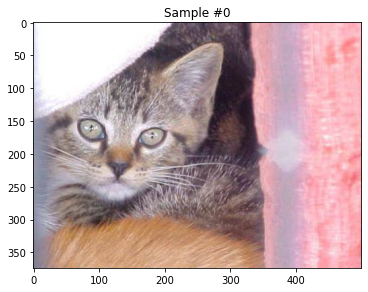

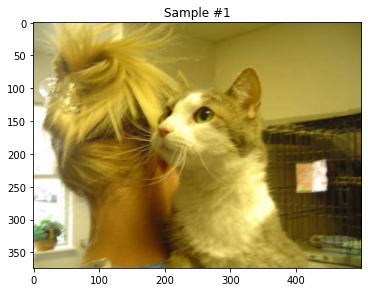

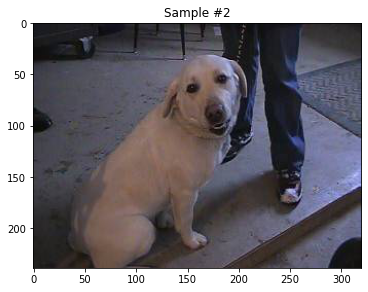

In [12]:
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(dogdataset))
    sample = dogdataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['category'])

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    plt.imshow(sample['image'])

In [13]:
for i in range(5):
    sample = transformed_dataset[i]
    print(sample['image'].size())

torch.Size([1, 230, 230])
torch.Size([1, 230, 230])
torch.Size([1, 230, 230])
torch.Size([1, 230, 230])
torch.Size([1, 230, 230])


## Training the Network
### Loading network

In [14]:
from model import Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=80000, out_features=2086, bias=True)
  (fc2): Linear(in_features=2086, out_features=2, bias=True)
)


### Batching and Loading Data

In [15]:
batch_size = 64
train_loader = DataLoader(transformed_dataset,
                          batch_size=batch_size,
                          shuffle=True)

### Defining Loss and Optimization

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.005)

In [17]:
from tqdm import tqdm
from torch.autograd import Variable

In [20]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in tqdm(enumerate(train_loader)):
            # convert variables to floats for regression loss
            
            #image, category = Variable(data['image']), Variable(data['category'])
            image = data['image']
            category = data['category']
            category = category.type(torch.LongTensor)
            image = image.type(torch.FloatTensor)
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            output = net(image)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output, category)


            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 5 == 4:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [ ]:
n_epochs = 1
train_net(n_epochs)

1it [00:12, 12.69s/it]

In [ ]:
testdataset = DogsCatsDataset(root_dir="./data/test1/", transform=data_transform)
test_loader = DataLoader(testdataset,batch_size=10,num_workers=0)

In [ ]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        category = sample['category']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_label = net(images)
        
        # break after first image is tested
        if i == 0:
            return images, output_label, category

In [ ]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, category = net_sample_output()

In [ ]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, category, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_label = test_outputs[i].data
        predicted_label = predicted_label.numpy()
        print(predicted_label)
        plt.imshow(np.squeeze(image), cmap='gray')
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, category)